In [1]:
#Importing a shit ton of stuff
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
import time
import json
import pandas as pd
import requests
from pandas import json_normalize
import os
import csv
pd.options.mode.chained_assignment = None
import seaborn as sns
import scikitplot as skplt
import scipy  
from scipy.cluster import hierarchy as hc
from collections import defaultdict
from rfpimp import *

# Machine learning
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
 
from imblearn.over_sampling import SMOTENC


from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import brier_score_loss

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification


from dtreeviz.trees import *
 
# Then run the code below if you get an error telling you that graphviz isn't in your system path (Windows users)
# https://stackoverflow.com/a/44625895
import os
your_graphviz_install_directory = 'C:/Users/bosem/anaconda3/Library/bin/graphviz'
os.environ["PATH"] += os.pathsep + your_graphviz_install_directory

C:\Users\bosem\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
#Import datafile to check, and the model
filename = 'Passesfrom201819.csv'
import pickle
model = pickle.load(open('final_model2.sav', 'rb'))

In [3]:
def model_fitter(filename, model):
    passes = pd.read_csv(filename,low_memory=False)
    passes['location'] = passes['location'].astype(str).str.strip('[]')
    passes['y_loc'] = passes['location'].str.split(', ').str.get(0).str.strip().astype(float)
    passes['x_loc'] = passes['location'].str.split(', ').str.get(1).str.strip().astype(float)
    passes['pass_end_location'] = passes['pass_end_location'].astype(str).str.strip('[]')
    passes['end_y_loc'] = passes['pass_end_location'].str.split(', ').str.get(0).str.strip().astype(float)
    passes['end_x_loc'] = passes['pass_end_location'].str.split(', ').str.get(1).str.strip().astype(float)
    # Reset index
    passes = passes.reset_index().drop('level_0', axis=1)
    # Create succes column
    passes.loc[passes['pass_outcome_name'].isnull(),'success'] = 1
    passes.loc[passes['pass_outcome_name'].notnull(), 'success'] = 0
    passes['x_dist'] = passes['end_x_loc'] - passes['x_loc'] + 1e-5
    passes['y_dist'] = passes['end_y_loc'] - passes['y_loc']
    passes['distance'] = np.sqrt((passes['x_dist']**2 + passes['y_dist']**2))
    passes['angle'] = np.abs(np.arctan2(passes['y_dist'],passes['x_dist']))
    feature_cols = ['player_name','duration', 'angle', 'pass_body_part_name', 'x_loc', 'y_loc', 'end_x_loc','end_y_loc',
                    'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_height_name', 'distance', 
                    'pass_switch', 'pass_through_ball', 'play_pattern_name', 'under_pressure', 'success']
    pass_final = passes[feature_cols]
    bool_cols = ['pass_cross', 'pass_cut_back', 'pass_deflected','pass_switch', 'pass_through_ball','under_pressure']
    for col in bool_cols:
        pass_final[col] = np.where(pass_final[col].isna(), 0, 1)
    extra_cols = ['player_name']
    extras = pass_final[extra_cols]
    pass_final = pass_final.drop(extra_cols, axis=1)
    features = pass_final.drop('success', axis=1)
    labels = pass_final['success']
    cont_cols = ['duration', 'angle', 'distance','x_loc', 'y_loc', 'end_x_loc','end_y_loc'] 
    cat_features = features.drop(cont_cols, axis=1)
    cont_features = features[cont_cols]
    def display_all(df):
        with pd.option_context("display.max_rows", 1000): 
            with pd.option_context("display.max_columns", 1000): 
                display(df.head(20).transpose())
    def label_encode(df):
        # Convert df to label encoded
        df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
        # Save mappings as a dict
        mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
         for col in df}
        return df_le, mappings
    cat_features_le, mappings = label_encode(cat_features)
    features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)
    X = features_le
    y = labels
    model.fit(X, y)
    df = X.copy()
    df['success'] = y
    df['xp'] = model.predict_proba(X)[:,1]
    df = df.merge(extras, left_index=True, right_index=True)
    return df

In [4]:
def model_check_start_x(df,ax):
    bin_size = 5
    bins = np.arange(0,80+bin_size,bin_size)
    df['binned'] = pd.cut(df['x_loc'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expectedsuccess = np.array(A.xp.tolist())
    actualsuccess = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::],100*actualsuccess,bins[1::],100*expectedsuccess)
    ax.set_xlabel("Starting x coordinate of pass")
    ax.set_ylabel("Pass completion probability")
    ax.legend(('Actual %','Expected %'))
    return ax

In [5]:
def model_check_end_x(df,ax):
    bin_size = 5
    bins = np.arange(0,80+bin_size,bin_size)
    df['binned'] = pd.cut(df['end_x_loc'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expectedsuccess = np.array(A.xp.tolist())
    actualsuccess = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::],100*actualsuccess,bins[1::],100*expectedsuccess)
    ax.set_xlabel("End x coordinate of pass")
    ax.set_ylabel("Pass completion probability")
    ax.legend(("Actual %","Expected %"))
    return ax

In [6]:
def model_check_start_y(df, ax):
    bin_size = 5
    bins = np.arange(0,120+bin_size,bin_size)
    df['binned'] = pd.cut(df['y_loc'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expectedsuccess = np.array(A.xp.tolist())
    actualsuccess = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::],100*actualsuccess,bins[1::],100*expectedsuccess)
    ax.set_xlabel("Starting y coordinate of pass")
    ax.set_ylabel("Pass completion probability")
    ax.legend(("Actual %","Expected %"))
    return ax

In [7]:
def model_check_end_y(df, ax):
    bin_size = 5
    bins = np.arange(0,120+bin_size,bin_size)
    df['binned'] = pd.cut(df['end_y_loc'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expectedsuccess = np.array(A.xp.tolist())
    actualsuccess = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::],100*actualsuccess,bins[1::],100*expectedsuccess)
    ax.set_xlabel("End y coordinate of pass")
    ax.set_ylabel("Pass completion probability")
    ax.legend(("Actual %","Expected %"))
    return ax

In [8]:
def model_check_distance(df, ax):
    bin_size = 5
    bins = np.arange(0,100+bin_size,bin_size)
    df['binned'] = pd.cut(df['distance'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expectedsuccess = np.array(A.xp.tolist())
    actualsuccess = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::],100*actualsuccess,bins[1::],100*expectedsuccess)
    ax.set_xlabel("Length of pass")
    ax.set_ylabel("Pass completion probability")
    ax.legend(("Actual %","Expected %"))
    return ax

In [9]:
def model_check_angle(df, ax):
    bin_size = 0.1
    bins = np.arange(0,3.2+bin_size,bin_size)
    df['binned'] = pd.cut(df['angle'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expectedsuccess = np.array(A.xp.tolist())
    actualsuccess = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::],100*actualsuccess,bins[1::],100*expectedsuccess)
    ax.set_xlabel("Absolute value of angle of pass")
    ax.set_ylabel("Pass completion probability")
    ax.legend(("Actual %","Expected %"))
    return ax

In [10]:
def model_check_pressure(df):
    actualpasssuccessunderpressure = df[df.under_pressure==1].success.sum()
    expectedpasssuccessunderpressure = df[df.under_pressure==1].xp.sum()
    return (actualpasssuccessunderpressure,expectedpasssuccessunderpressure)

In [11]:
df = model_fitter(filename,model)

Text(0.5, 0.98, 'Performance of model with different parameters')

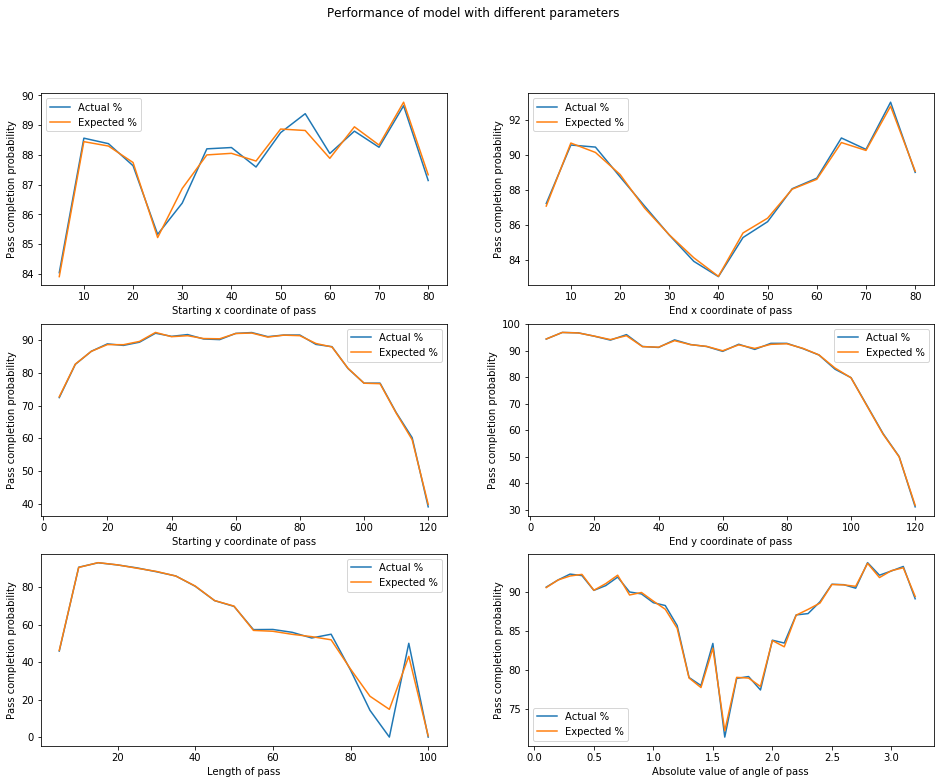

In [12]:
fig, ax = plt.subplots(3,2, figsize=(16,12))
model_check_start_x(df,ax = ax[0,0])
model_check_end_x(df,ax = ax[0,1])
model_check_start_y(df,ax = ax[1,0])
model_check_end_y(df,ax = ax[1,1])
model_check_distance(df,ax = ax[2,0])
model_check_angle(df,ax = ax[2,1])
fig.suptitle('Performance of model with different parameters')
# fig.savefig("modelcheck.png")

In [13]:
model_check_pressure(df)

(3190.0, 3191.155)

In [14]:
df.success.sum(),df.xp.sum(),len(df)

(19965.0, 19963.719, 22726)

In [15]:
# def player_passing(df, players):
# #     players = df.player_name.unique()
# #     players = ['Lionel Andrés Messi Cuccittini']
#     player_pass_completed = np.zeros(len(players))
#     player_xP = np.zeros(len(players))
#     player_xP_rating = np.zeros(len(players))
#     player_avg_xP = np.zeros(len(players))
#     for i in range(len(players)):
#         pl_df = df[df.player_name==players[i]]
#         player_pass_completed[i] = pl_df.success.sum()
#         player_xP[i] = pl_df.xp.sum()
#         player_avg_xP[i] = pl_df.xp.mean()
#         player_xP_rating[i] = player_pass_completed[i]/player_xP[i]
#     avg_rating = [np.mean(player_xP_rating)]*len(player_avg_xP)
#     avg_xP = [np.mean(player_avg_xP)]*len(player_xP_rating)
#     print(player_xP_rating,players,player_avg_xP)
#     plt.scatter(player_avg_xP,player_xP_rating)
#     plt.plot(np.sort(player_avg_xP),avg_rating,linestyle='--',c='r')
#     plt.plot(avg_xP,np.sort(player_xP_rating),linestyle='--',c='orange')

In [16]:
players201011 = ['Sergio Busquets i Burgos', 'Andrés Iniesta Luján', 'Xavier Hernández Creus',
       'Lionel Andrés Messi Cuccittini',  'Seydou Kéita', 'Thiago Alcântara do Nascimento']
players201415 = ['Lionel Andrés Messi Cuccittini', 'Sergio Busquets i Burgos',
       'Andrés Iniesta Luján','Neymar da Silva Santos Junior', 'Ivan Rakitić', 'Xavier Hernández Creus']
players201718 = ['Sergio Busquets i Burgos', 'Andrés Iniesta Luján','José Paulo Bezzera Maciel Júnior',
       'Lionel Andrés Messi Cuccittini', 'Philippe Coutinho Correia', 'Ivan Rakitić']
players201819 = ['Sergio Busquets i Burgos', 'Arturo Erasmo Vidal Pardo', 'Arthur Henrique Ramos de Oliveira Melo',
     'Lionel Andrés Messi Cuccittini','Ivan Rakitić','Gerard Piqué Bernabéu']

In [17]:
# To do, bin individual player passes 
def player_check(df, ax):
    name = [df.player_name.unique().item(),'Baseline']
    bin_size = 0.05
    bins = np.arange(0,1+bin_size,bin_size)
    df['binned'] = pd.cut(df['xp'], bins, include_lowest=True, right = True)
    df["Bin_Mids"] = df["binned"].apply(lambda x: x.mid)
    df = df[:-1]
    A = df.groupby("Bin_Mids", as_index=False)["xp"].mean()
    B = df.groupby("Bin_Mids", as_index=False)["success"].mean()
    expected = np.array(A.xp.tolist())
    actual = np.array(B.success.tolist())
    ax = ax
    ax.plot(bins[1::]*100,actual*100,bins[1::]*100,bins[1::]*100)
    ax.set_xlabel("Expected Pass Completion %")
    ax.set_ylabel("Actual Pass Completion %")
    ax.legend(name)
    return ax

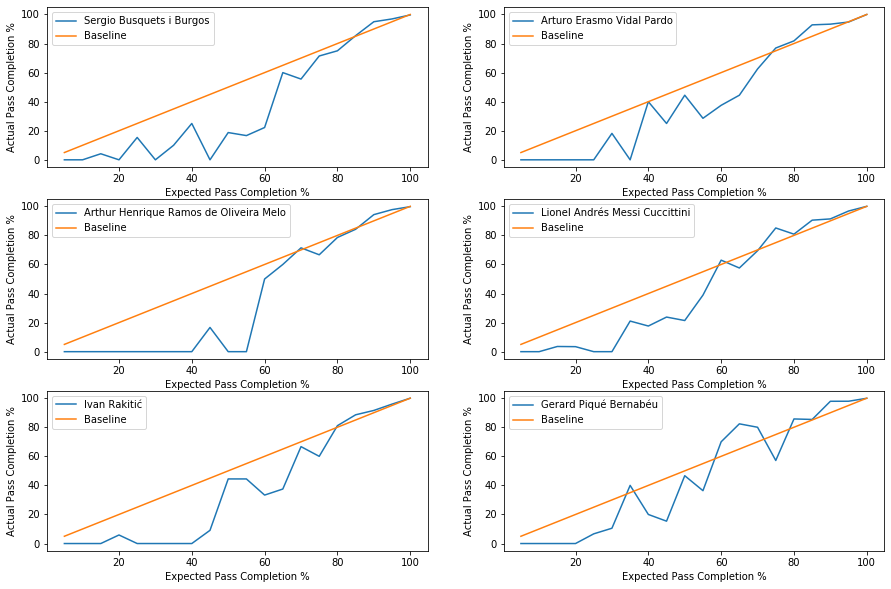

In [18]:
fig, ax = plt.subplots(3,2,figsize=(15,10))
for i in range(len(players201819)):
    pname = players201819[i]
    playerdf = df.query("(player_name==@pname)")
    player_check(playerdf, ax[i//2,i%2])
fig.savefig("passing201819.png")